# Разработка системы анализа медицинских изображений
## для эпидемиологического мониторинга на основе Apache Spark

**Цель:** Анализ метаданных рентгеновских снимков COVID-19 для выявления эпидемиологических закономерностей

**Датасет:** COVID-19 Chest X-Ray Metadata

**Технологии:** Apache Spark (PySpark), Spark SQL, Python




#1. Подготовка среды


In [34]:
# Java
import subprocess, sys

def ensure_java():
    try:
        subprocess.run(
            ["java", "-version"],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
            check=True
        )
    except Exception:
        if "google.colab" not in sys.modules:
            raise RuntimeError("Java not found. Install JDK 11/17.")
        subprocess.run(["apt-get", "update"], check=True)
        subprocess.run(["apt-get", "install", "-y", "openjdk-17-jdk"], check=True)

ensure_java()

In [35]:
# PySpark
def ensure_pyspark():
    try:
        import pyspark
    except ImportError:
        subprocess.run(
            [sys.executable, "-m", "pip", "install", "-q", "pyspark"],
            check=True
        )

ensure_pyspark()

In [37]:
# Импорты
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, avg, desc, when, isnan, percentile_approx, udf, year, month, row_number, concat, lpad,
    max as spark_max, min as spark_min,
    sum as spark_sum
)

from pyspark.sql.types import StringType, DateType, IntegerType
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [38]:
# Инициализация Spark
spark = SparkSession.builder \
    .appName("COVID-19 X-Ray Analysis") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.repl.eagerEval.maxNumRows", 10) \
    .getOrCreate()

# 2. Предобработка и анализ качества данных


In [39]:
# Загрузка датасета
# Скачиваем metadata.csv из репозитория
!wget -q https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv
df = spark.read.csv(
    'metadata.csv',
    header=True,
    inferSchema=True
)
# Кеширование после загрузки
df.cache()
df.count()  # Материализует кэш

print(f"   Записей: {df.count()}")
print(f"   Полей: {len(df.columns)}")

   Записей: 950
   Полей: 30


In [40]:
df.printSchema()        # схема (типы колонок)

root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: string (nullable 

   Полей с пропусками >80%: 8
   Полей с пропусками >50%: 15
   Полей с пропусками <20%: 10


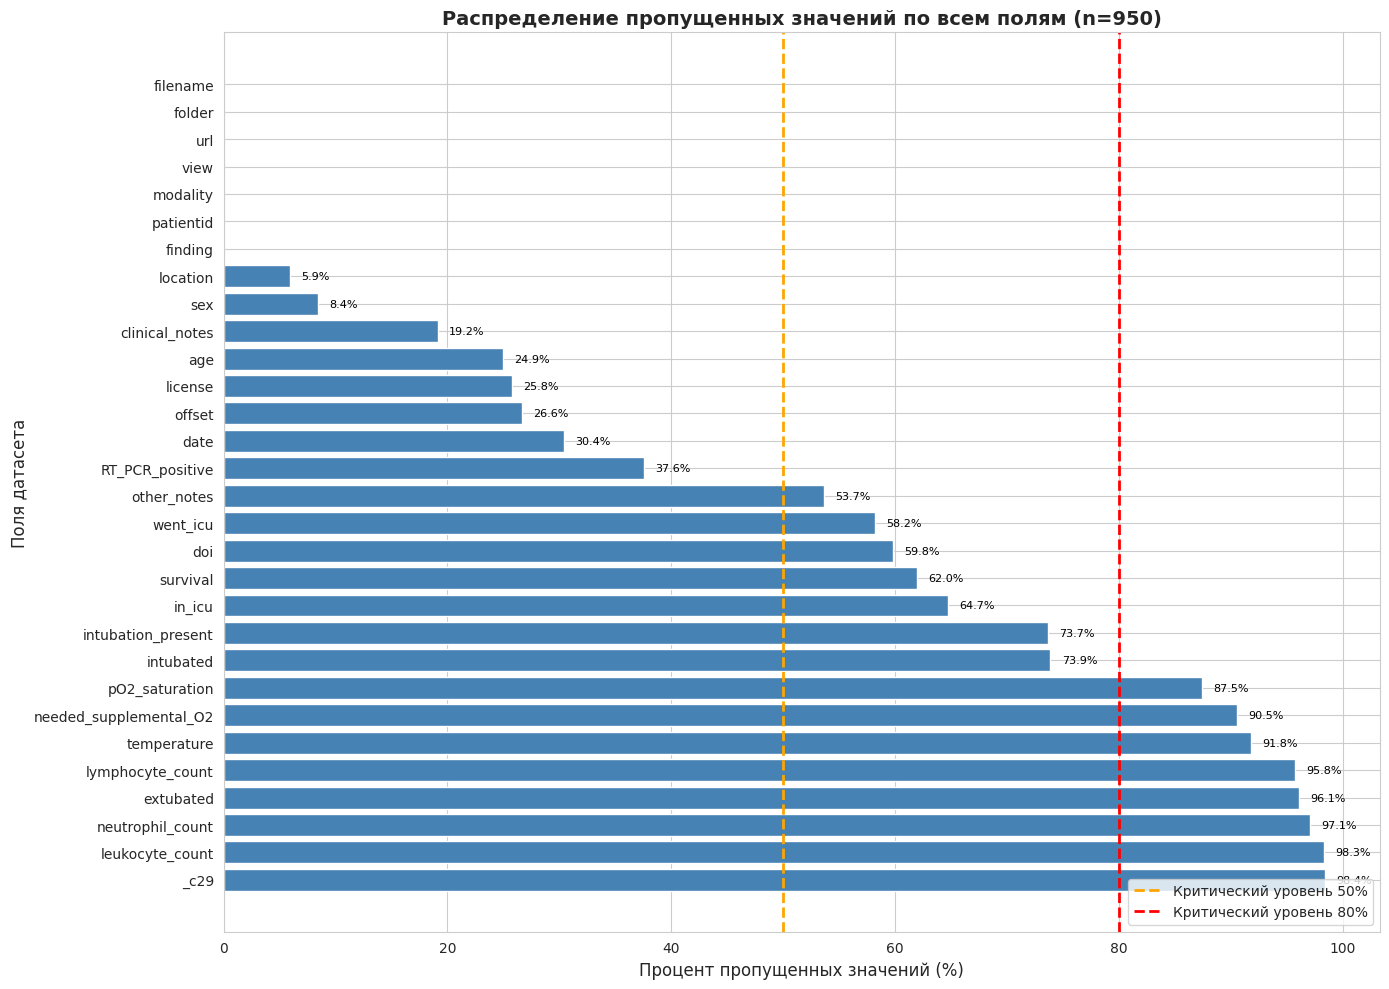

In [41]:
# Подсчитываем пропуски
total = df.count()
null_counts = df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).collect()[0].asDict()

# Создаем pandas DataFrame для удобного вывода
missing_data = []
for col_name in df.columns:
    null_count = null_counts[col_name]
    percentage = (null_count / total) * 100
    missing_data.append({
        'field': col_name,
        'missing_count': null_count,
        'missing_percent': percentage
    })

missing_df = pd.DataFrame(missing_data)
missing_df = missing_df.sort_values('missing_percent', ascending=False)

print(f"   Полей с пропусками >80%: {len(missing_df[missing_df['missing_percent'] > 80])}")
print(f"   Полей с пропусками >50%: {len(missing_df[missing_df['missing_percent'] > 50])}")
print(f"   Полей с пропусками <20%: {len(missing_df[missing_df['missing_percent'] < 20])}")

# Распределение пропущенных значений
plt.figure(figsize=(14, 10))
bars = plt.barh(missing_df['field'], missing_df['missing_percent'], color='steelblue')

# Добавляем проценты на бары
for idx, (bar, pct) in enumerate(zip(bars, missing_df['missing_percent'])):
    if pct > 2:  # Показываем текст только если > 2%
        plt.text(pct + 1, idx, f'{pct:.1f}%',
                 va='center', fontsize=8, color='black')

plt.xlabel('Процент пропущенных значений (%)', fontsize=12)
plt.ylabel('Поля датасета', fontsize=12)
plt.title(f'Распределение пропущенных значений по всем полям (n={total})',
          fontsize=14, fontweight='bold')

# Линии критических уровней
plt.axvline(x=50, color='orange', linestyle='--', linewidth=2,
            label='Критический уровень 50%')
plt.axvline(x=80, color='red', linestyle='--', linewidth=2,
            label='Критический уровень 80%')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [42]:
# Анализ аномальных значений Agе
# Статистика в Spark
age_stats = df.select(
    spark_min('age').alias('min'),
    spark_max('age').alias('max'),
    avg('age').alias('mean'),
    spark_sum(when(col('age').isNull(), 1).otherwise(0)).alias('nulls')
).collect()[0]

print(f"\n   Статистика:")
print(f"      Минимум: {age_stats['min']}")
print(f"      Максимум: {age_stats['max']}")
print(f"      Среднее: {age_stats['mean']:.1f}")
print(f"      Пропусков: {age_stats['nulls']}")

# Проверка аномалий
age_negative = df.filter(col('age') < 0).count()
age_over_120 = df.filter(col('age') > 120).count()
age_zero = df.filter(col('age') == 0).count()

print(f"\n   Аномалии:")
print(f"      Отрицательный возраст: {age_negative}")
print(f"      Возраст = 0: {age_zero}")
print(f"      Возраст > 120: {age_over_120}")


   Статистика:
      Минимум: 18
      Максимум: 94
      Среднее: 53.5
      Пропусков: 237

   Аномалии:
      Отрицательный возраст: 0
      Возраст = 0: 0
      Возраст > 120: 0


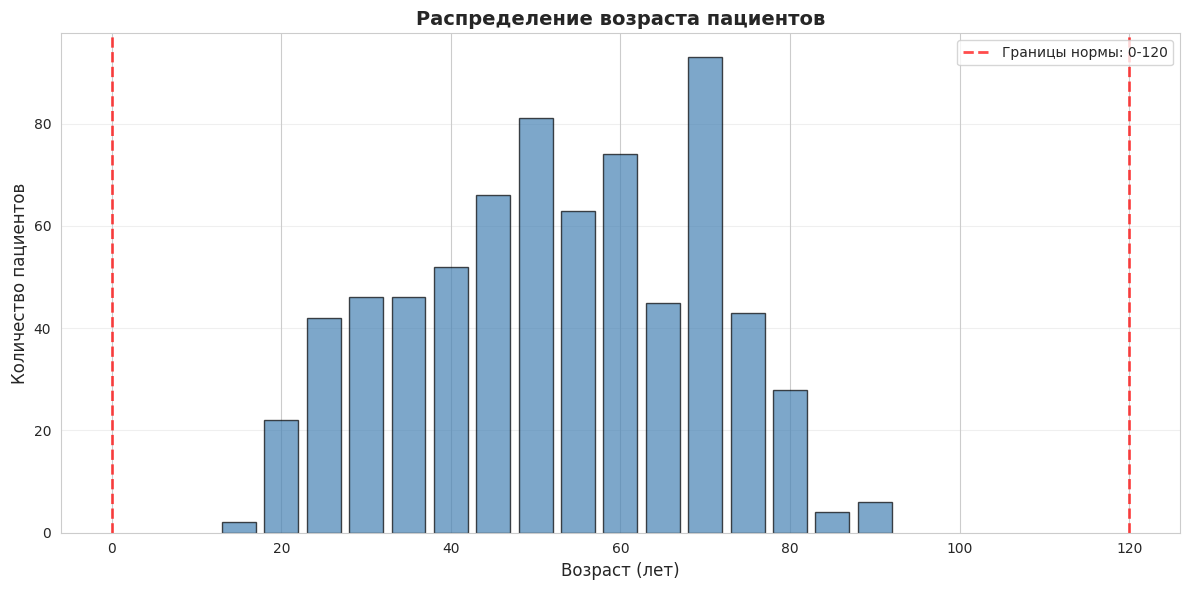

In [43]:
# bins в Spark SQL по 5 лет
age_distribution = df.filter(col('age').isNotNull()) \
    .selectExpr(
        "CAST(FLOOR(age / 5) * 5 AS INT) as age_bin",
        "age"
    ) \
    .groupBy('age_bin').count() \
    .orderBy('age_bin')

# в Pandas только агрегированные данные
age_data = age_distribution.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(age_data['age_bin'], age_data['count'],
        width=4, color='steelblue', edgecolor='black', alpha=0.7)

# Линии границ нормы
plt.axvline(0, color='red', linestyle='--', linewidth=2,
            label='Границы нормы: 0-120', alpha=0.7)
plt.axvline(120, color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.xlabel('Возраст (лет)', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.title('Распределение возраста пациентов', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [44]:
# Анализ дат - пропуски
date_nulls = df.filter(col('date').isNull()).count()
date_percentage = (date_nulls / df.count()) * 100
print(f"\n   Пропусков в date: {date_nulls} ({date_percentage:.1f}%)")

# ПАРСИНГ ДАТ
formats = [
    "%Y-%m-%d", "%B %d, %Y", "%b %d, %Y", "%d %B %Y", "%d %b %Y",
    "%m/%d/%Y", "%m/%d/%y", "%B %Y", "%b %Y",
    "%Y", "%B %d", "%b %d"
]

def parse_date(date_str):
    if not date_str or date_str == 'NULL':
        return None
    for fmt in formats:
        try:
            result = datetime.strptime(str(date_str).strip(), fmt).date()
            if fmt in ["%B %d", "%b %d"]:
                result = result.replace(year=2020)
            return result
        except:
            continue
    return None

# Регистрируем UDF
parse_date_udf = udf(parse_date, DateType())

# Парсим во временную колонку
df_with_parsed = df.withColumn('date_parsed', parse_date_udf(col('date')))

# Статистика
total_dates = df.filter(col('date').isNotNull()).count()
parsed_dates = df_with_parsed.filter(col('date_parsed').isNotNull()).count()
failed_dates = df_with_parsed.filter(
    col('date').isNotNull() & col('date_parsed').isNull()
).count()

print(f"\n   Парсинг дат:")
print(f"      Непустых дат: {total_dates}")
print(f"      Распарсено: {parsed_dates}")
print(f"      Не распарсено: {failed_dates}")

# Анализ
if parsed_dates > 0:
    current_year = datetime.now().year

    year_distribution = df_with_parsed.filter(col('date_parsed').isNotNull()) \
        .withColumn('year', year(col('date_parsed'))) \
        .groupBy('year').count() \
        .orderBy('year')

    year_data = year_distribution.toPandas()

    if len(year_data) > 0:
        print(f"\n   Период: {int(year_data['year'].min())} - {int(year_data['year'].max())}")
        print(f"\n   По годам:")
        for _, row in year_data.iterrows():
            print(f"      {int(row['year'])}: {row['count']} записей")

df = df_with_parsed.drop('date')  # Удаляем старую строковую колонку
df = df.withColumnRenamed('date_parsed', 'date')  # Переименовываем


   Пропусков в date: 289 (30.4%)

   Парсинг дат:
      Непустых дат: 661
      Распарсено: 661
      Не распарсено: 0

   Период: 2003 - 2020

   По годам:
      2003: 5 записей
      2004: 11 записей
      2007: 1 записей
      2009: 3 записей
      2010: 6 записей
      2011: 5 записей
      2013: 7 записей
      2014: 11 записей
      2015: 25 записей
      2016: 20 записей
      2017: 4 записей
      2018: 6 записей
      2019: 10 записей
      2020: 547 записей


### Обнаруженные проблемы в данных:

Высокий процент пропусков в большинстве полей (технические, геолокационные данные и клинические детали). Эти поля не могут быть использованы для анализа.

Даты имеют неоднородный характер (множественные форматы, требуется унификация)

Пропуски в ключевых демографических полях - требуется заполнение статистическими методам




### Обоснование выбора полей для эпидемиологического анализа:

Поскольку целью анализа является эпидемиологический мониторинг COVID-19 (анализ заболеваемости по демографическим группам, временная динамика и эффективность диагностики) отбираем поля:

| # | Поле | Обоснование | Пропуски |
|---|------|-------------|----------|
| 1 | **patientid** | Идентификатор пациента (удаление дубликатов, связь записей) | ~5% |
| 2 | **age** | Возраст (анализ групп риска, возрастная динамика) | ~30% |
| 3 | **sex** | Пол (гендерный анализ заболеваемости и тяжести) | ~40% |
| 4 | **finding** | Диагноз (основная целевая переменная анализа) | ~5% |
| 5 | **view** | Проекция снимка (оценка качества диагностики) | ~30% |
| 6 | **date** | Дата исследования (временной анализ, динамика эпидемии) | ~40% |

**Итого: 6 полей** обеспечивают полноценный эпидемиологический анализ.



In [45]:
selected_columns = ['patientid', 'age', 'sex', 'finding', 'view', 'date']
df = df.select(*selected_columns)

print(f"\n   Выбранные поля: {selected_columns}")
print("\n   Примеры данных:")
df.show(5, truncate=False)


   Выбранные поля: ['patientid', 'age', 'sex', 'finding', 'view', 'date']

   Примеры данных:
+---------+---+---+------------------------+----+----------+
|patientid|age|sex|finding                 |view|date      |
+---------+---+---+------------------------+----+----------+
|2        |65 |M  |Pneumonia/Viral/COVID-19|PA  |2020-01-22|
|2        |65 |M  |Pneumonia/Viral/COVID-19|PA  |2020-01-25|
|2        |65 |M  |Pneumonia/Viral/COVID-19|PA  |2020-01-27|
|2        |65 |M  |Pneumonia/Viral/COVID-19|PA  |2020-01-28|
|4        |52 |F  |Pneumonia/Viral/COVID-19|PA  |2020-01-25|
+---------+---+---+------------------------+----+----------+
only showing top 5 rows


### Удаление дубликатов

In [46]:
records_before = df.count()
df = df.dropDuplicates()
records_after = df.count()
duplicates_removed = records_before - records_after

print(f"   Было записей: {records_before}")
print(f"   Стало записей: {records_after}")
print(f"   Удалено дубликатов: {duplicates_removed}")

   Было записей: 950
   Стало записей: 668
   Удалено дубликатов: 282


### Заполнение пропусков


In [47]:
df = df.withColumn(
    "age",
    when(col("age").isNotNull() & isnan(col("age")), None).otherwise(col("age"))
)
# Считаем все до заполнения
stats_before = df.agg(
    spark_sum(when(col('age').isNull(), 1)).alias('age_nulls'),
    spark_sum(when(col('sex').isNull(), 1)).alias('sex_nulls'),
    spark_sum(when(col('view').isNull(), 1)).alias('view_nulls'),
    spark_sum(when(col('date').isNull(), 1)).alias('date_nulls'),
    percentile_approx('age', 0.5).alias('median_age')
).collect()[0]

# Извлекаем значения
age_nulls_before = stats_before['age_nulls']
median_age = stats_before['median_age']
sex_nulls_before = stats_before['sex_nulls']
view_nulls_before = stats_before['view_nulls']
date_nulls_before = stats_before['date_nulls']

# Моды
sex_mode = df.filter(col('sex').isNotNull()) \
    .groupBy('sex').count() \
    .orderBy(desc('count')) \
    .first()[0]

view_mode = df.filter(col('view').isNotNull()) \
    .groupBy('view').count() \
    .orderBy(desc('count')) \
    .first()[0]

# Заполняем
df = df.withColumn('age', when(col('age').isNull(), median_age).otherwise(col('age'))) \
       .withColumn('sex', when(col('sex').isNull(), sex_mode).otherwise(col('sex'))) \
       .withColumn('view', when(col('view').isNull(), view_mode).otherwise(col('view')))

# КЭШ
df.cache()
df.count()  # Материализация

# Проверка
stats_after = df.agg(
    spark_sum(when(col('age').isNull(), 1)).alias('age_nulls'),
    spark_sum(when(col('sex').isNull(), 1)).alias('sex_nulls'),
    spark_sum(when(col('view').isNull(), 1)).alias('view_nulls')
).collect()[0]

### Унификация диагнозов


In [48]:
# Функция унификации диагнозов
def unify_finding(finding):
    """Унифицирует диагнозы в 5 категорий"""
    if finding is None or str(finding).strip() == '':
        return 'Other'  # Пропуски → Other

    f = str(finding).lower().strip()

    if 'covid' in f or 'corona' in f:
        return 'COVID-19'
    if 'pneumonia' in f:
        return 'Pneumonia'
    if 'tuberculosis' in f or f == 'tb':
        return 'Tuberculosis'
    if 'normal' in f or 'no finding' in f:
        return 'Normal'

    return 'Other'

# Регистрируем UDF
unify_finding_udf = udf(unify_finding, StringType())

# создаем новую колонку с унифицированным диагнозом
df = df.withColumn('finding_unified', unify_finding_udf(col('finding')))

print("\nРаспределение по категориям:")
df.groupBy('finding_unified').count().orderBy(desc('count')).show()

# КЭШИРУЕМ
df.cache()
df.count()


Распределение по категориям:
+---------------+-----+
|finding_unified|count|
+---------------+-----+
|       COVID-19|  437|
|      Pneumonia|  166|
|          Other|   28|
|         Normal|   20|
|   Tuberculosis|   17|
+---------------+-----+



668

In [49]:
# Удаляем старую колонку finding (оставляем только finding_unified)
df = df.drop('finding')

###Финальная проверка качества данных после трансформаций.


In [50]:
# Проверка пропусков
null_counts_final = df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).collect()[0].asDict()

all_clean = True
for col_name in df.columns:
    null_count = null_counts_final[col_name]
    if null_count > 0:
        print(f"   {col_name}: {null_count} пропусков")
        all_clean = False

if all_clean:
    print("   Пропусков нет!")

   date: 204 пропусков


# 3. SQL Analytics

In [51]:
# Создаем SQL view
df.createOrReplaceTempView('covid_data')

## Запрос 1: Базовая статистика по диагнозам


In [52]:
spark.sql("""
    SELECT
        finding_unified,
        COUNT(*) AS count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS percentage,
        ROUND(AVG(age), 1) AS avg_age,
        MIN(age) AS min_age,
        MAX(age) AS max_age
    FROM covid_data
    GROUP BY finding_unified
    ORDER BY count DESC
""").show()

+---------------+-----+----------+-------+-------+-------+
|finding_unified|count|percentage|avg_age|min_age|max_age|
+---------------+-----+----------+-------+-------+-------+
|       COVID-19|  437|     65.42|   55.6|     20|     94|
|      Pneumonia|  166|     24.85|   49.9|     18|     90|
|          Other|   28|      4.19|   54.0|     54|     54|
|         Normal|   20|      2.99|   53.5|     22|     78|
|   Tuberculosis|   17|      2.54|   42.4|     20|     78|
+---------------+-----+----------+-------+-------+-------+



## Запрос 2: Распределение по полу и диагнозам


In [53]:
spark.sql("""
    SELECT
        sex,
        finding_unified,
        COUNT(*) AS count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY sex), 2) AS percentage
    FROM covid_data
    GROUP BY sex, finding_unified
    ORDER BY sex, count DESC
""").show()

+---+---------------+-----+----------+
|sex|finding_unified|count|percentage|
+---+---------------+-----+----------+
|  F|       COVID-19|  129|     62.02|
|  F|      Pneumonia|   59|     28.37|
|  F|         Normal|    9|      4.33|
|  F|          Other|    6|      2.88|
|  F|   Tuberculosis|    5|      2.40|
|  M|       COVID-19|  308|     66.96|
|  M|      Pneumonia|  107|     23.26|
|  M|          Other|   22|      4.78|
|  M|   Tuberculosis|   12|      2.61|
|  M|         Normal|   11|      2.39|
+---+---------------+-----+----------+



## Запрос 3: Оконная функция - топ-3 по возрасту


In [54]:
query3 = """
SELECT
    finding_unified,
    patientid,
    CAST(age AS INT) as age,
    sex,
    age_rank
FROM (
    SELECT
        finding_unified,
        patientid,
        age,
        sex,
        ROW_NUMBER() OVER (PARTITION BY finding_unified ORDER BY age DESC) as age_rank
    FROM covid_data
)
WHERE age_rank <= 3
ORDER BY finding_unified, age_rank
"""

print("Топ-3 самых старших пациентов в каждой группе")
spark.sql(query3).show(20)

Топ-3 самых старших пациентов в каждой группе
+---------------+---------+---+---+--------+
|finding_unified|patientid|age|sex|age_rank|
+---------------+---------+---+---+--------+
|       COVID-19|     326b| 94|  M|       1|
|       COVID-19|     324b| 93|  F|       2|
|       COVID-19|      200| 88|  M|       3|
|         Normal|      315| 78|  F|       1|
|         Normal|      325| 78|  F|       2|
|         Normal|      478| 75|  F|       3|
|          Other|      388| 54|  M|       1|
|          Other|      429| 54|  F|       2|
|          Other|      439| 54|  M|       3|
|      Pneumonia|      460| 90|  M|       1|
|      Pneumonia|      460| 90|  M|       2|
|      Pneumonia|       91| 80|  F|       3|
|   Tuberculosis|      421| 78|  M|       1|
|   Tuberculosis|      453| 70|  M|       2|
|   Tuberculosis|      456| 58|  M|       3|
+---------------+---------+---+---+--------+



## Запрос 4: Временные тренды по датам


In [55]:
query4 = """
SELECT
    YEAR(date) as year,
    MONTH(date) as month,
    finding_unified,
    COUNT(*) as cases,
    COUNT(DISTINCT patientid) as unique_patients,
    ROUND(AVG(CAST(age AS INT)), 1) as avg_age
FROM covid_data
WHERE date IS NOT NULL
GROUP BY YEAR(date), MONTH(date), finding_unified
ORDER BY year DESC, month DESC, cases DESC
"""

print("Временные тренды по датам исследований")
spark.sql(query4).show(20)

Временные тренды по датам исследований
+----+-----+---------------+-----+---------------+-------+
|year|month|finding_unified|cases|unique_patients|avg_age|
+----+-----+---------------+-----+---------------+-------+
|2020|    4|       COVID-19|    1|              1|   71.0|
|2020|    3|       COVID-19|   30|             17|   57.4|
|2020|    3|      Pneumonia|    4|              2|   56.0|
|2020|    3|         Normal|    2|              2|   78.0|
|2020|    2|       COVID-19|   17|              9|   59.2|
|2020|    1|       COVID-19|  303|            239|   55.2|
|2020|    1|          Other|   27|             26|   54.0|
|2020|    1|         Normal|    6|              6|   57.8|
|2019|   12|       COVID-19|    4|              2|   52.5|
|2019|   11|      Pneumonia|    1|              1|   55.0|
|2019|    5|      Pneumonia|    1|              1|   65.0|
|2019|    2|      Pneumonia|    1|              1|   50.0|
|2019|    1|         Normal|    2|              1|   61.0|
|2018|    1|     

## Запрос 5: Статистика по проекциям снимков


In [56]:
query5 = """
SELECT
    view,
    finding_unified,
    COUNT(*) as cases,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY view), 2) as pct_in_view
FROM covid_data
GROUP BY view, finding_unified
ORDER BY view, cases DESC
"""

print("Связь проекций снимков и диагнозов")
spark.sql(query5).show(20)


Связь проекций снимков и диагнозов
+---------+---------------+-----+-----------+
|     view|finding_unified|cases|pct_in_view|
+---------+---------------+-----+-----------+
|       AP|       COVID-19|  106|      71.62|
|       AP|      Pneumonia|   35|      23.65|
|       AP|         Normal|    5|       3.38|
|       AP|   Tuberculosis|    2|       1.35|
| AP Erect|      Pneumonia|    1|     100.00|
|AP Supine|       COVID-19|   94|      72.87|
|AP Supine|          Other|   18|      13.95|
|AP Supine|      Pneumonia|   15|      11.63|
|AP Supine|         Normal|    2|       1.55|
|    Axial|       COVID-19|   44|      93.62|
|    Axial|         Normal|    3|       6.38|
|  Coronal|       COVID-19|   12|     100.00|
|        L|      Pneumonia|   39|      55.71|
|        L|       COVID-19|   25|      35.71|
|        L|   Tuberculosis|    6|       8.57|
|       PA|       COVID-19|  156|      59.77|
|       PA|      Pneumonia|   76|      29.12|
|       PA|         Normal|   10|       3.83|

# 4. Обработка в PySpark


### Категоризация возраста

In [57]:
def categorize_age(age):
    """Категоризирует возраст по классификации ВОЗ"""
    try:
        age = float(age)
    except:
        return "Unknown"

    if age < 18:
        return '0-17 (Ребенок)'
    elif age < 45:
        return '18-44 (Молодой)'
    elif age < 60:
        return '45-59 (Средний)'
    elif age < 75:
        return '60-74 (Пожилой)'
    elif age < 91:
        return '75-90 (Старческий)'
    else:
        return '90+ (Долгожители)'

# Регистрируем UDF
categorize_age_udf = udf(categorize_age, StringType())

# Применяем
df = df.withColumn('age_category', categorize_age_udf(col('age')))

print("\nРаспределение по возрастным группам:")
df.groupBy('age_category').count().orderBy('age_category').show()
# Перекэшируем
df.cache()
df.count()


Распределение по возрастным группам:
+------------------+-----+
|      age_category|count|
+------------------+-----+
|   18-44 (Молодой)|  160|
|   45-59 (Средний)|  289|
|   60-74 (Пожилой)|  153|
|75-90 (Старческий)|   64|
| 90+ (Долгожители)|    2|
+------------------+-----+



668

## Унификация диагнозов

In [58]:
# выполнена ранее, проверяем
df.groupBy('finding_unified').count().orderBy(desc('count')).show()

+---------------+-----+
|finding_unified|count|
+---------------+-----+
|       COVID-19|  437|
|      Pneumonia|  166|
|          Other|   28|
|         Normal|   20|
|   Tuberculosis|   17|
+---------------+-----+



## Фильтрация данных


In [59]:
# Пожилые (60+) с COVID-19
elderly_covid = df.filter(
    (col('age') >= 60) & (col('finding_unified') == 'COVID-19')
)
print(f'Пожилые (60+) с COVID-19 = {elderly_covid.count()} записей')

# Молодые (до 44 включительно) с пневмонией
young_pneumonia = df.filter(
    (col('age') < 45) & (col('finding_unified') == 'Pneumonia')
)
print(f'Молодые (до 44 включительно) с пневмонией = {young_pneumonia.count()} записей')

# Взрослые (18-59) мужчины с COVID-19
adult_male_covid = df.filter(
    (col('age').between(18, 59)) &
    (col('sex') == 'M') &
    (col('finding_unified') == 'COVID-19')
)
print(f'Взрослые мужчины (18-59) с COVID-19 = {adult_male_covid.count()} записей')

# Женщины с любым диагнозом, проекция PA
female_pa = df.filter(
    (col('sex') == 'F') & (col('view') == 'PA')
)
print(f'Женщины с проекцией PA = {female_pa.count()} записей')

# COVID-19 или Pneumonia у молодых (18-44)
young_adults_respiratory = df.filter(
    (col('age_category') == '18-44 (Молодой)') &
    (col('finding_unified').isin(['COVID-19', 'Pneumonia']))
)
print(f'Молодые с COVID-19 или пневмонией = {young_adults_respiratory.count()} записей')

Пожилые (60+) с COVID-19 = 156 записей
Молодые (до 44 включительно) с пневмонией = 58 записей
Взрослые мужчины (18-59) с COVID-19 = 205 записей
Женщины с проекцией PA = 88 записей
Молодые с COVID-19 или пневмонией = 145 записей


## Сохранение в Parquet


In [60]:
# Сохранение полной базы в Parquet
output_path = '/tmp/covid_analysis_results.parquet'

df.coalesce(1).write.mode('overwrite').parquet(output_path)

print(f" Сохранено в Parquet: {output_path}")
print(f"   Записей: {df.count()}")

# Проверка
spark.read.parquet(output_path).show(10, truncate=False)


 Сохранено в Parquet: /tmp/covid_analysis_results.parquet
   Записей: 668
+---------+---+---+---------+----------+---------------+------------------+
|patientid|age|sex|view     |date      |finding_unified|age_category      |
+---------+---+---+---------+----------+---------------+------------------+
|97       |70 |F  |PA       |2020-01-01|COVID-19       |60-74 (Пожилой)   |
|326a     |81 |M  |AP       |2020-01-01|COVID-19       |75-90 (Старческий)|
|476      |25 |M  |PA       |2020-01-01|COVID-19       |18-44 (Молодой)   |
|253      |54 |M  |PA       |2020-01-01|Normal         |45-59 (Средний)   |
|371      |45 |F  |PA       |NULL      |Pneumonia      |45-59 (Средний)   |
|452      |40 |F  |L        |NULL      |Tuberculosis   |18-44 (Молодой)   |
|16       |59 |F  |PA       |2020-01-01|COVID-19       |45-59 (Средний)   |
|36       |67 |M  |Axial    |2020-01-01|COVID-19       |60-74 (Пожилой)   |
|215      |38 |M  |AP       |NULL      |COVID-19       |18-44 (Молодой)   |
|236      |54 

# 5. Визуализация

In [61]:
# Настройки визуализации
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Круговая диаграмма распределения диагнозов


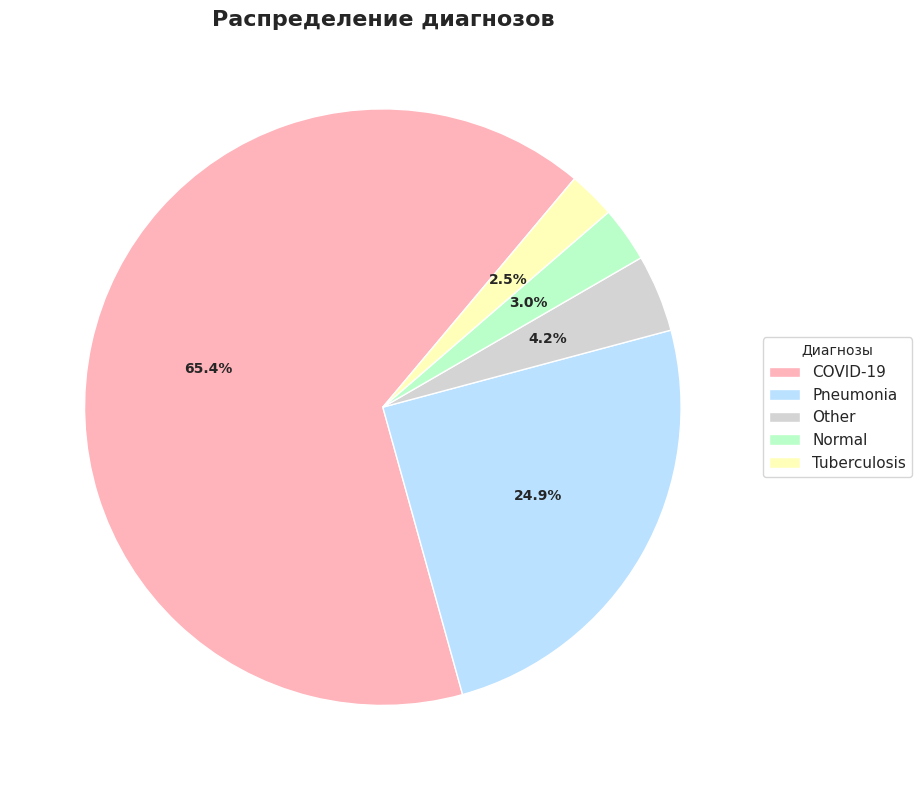

In [62]:
# Агрегация в Spark, потом toPandas
diagnosis_counts = df.groupBy('finding_unified').count().orderBy(desc('count'))
df_pandas = diagnosis_counts.toPandas()

plt.figure(figsize=(12, 8))

colors = ['#ffb3ba', '#bae1ff', '#d4d4d4', '#baffc9', '#ffffba']

# График БЕЗ labels на секторах
wedges, texts, autotexts = plt.pie(
    df_pandas['count'],
    autopct='%1.1f%%',
    startangle=50,
    colors=colors,
    textprops={'fontsize': 10, 'weight': 'bold'}
)

plt.title('Распределение диагнозов',
          fontsize=16,
          fontweight='bold')

plt.legend(
    wedges,
    df_pandas['finding_unified'],
    title="Диагнозы",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=11
)

plt.tight_layout()
plt.show()


## Столбчатая диаграмма по возрастным группам


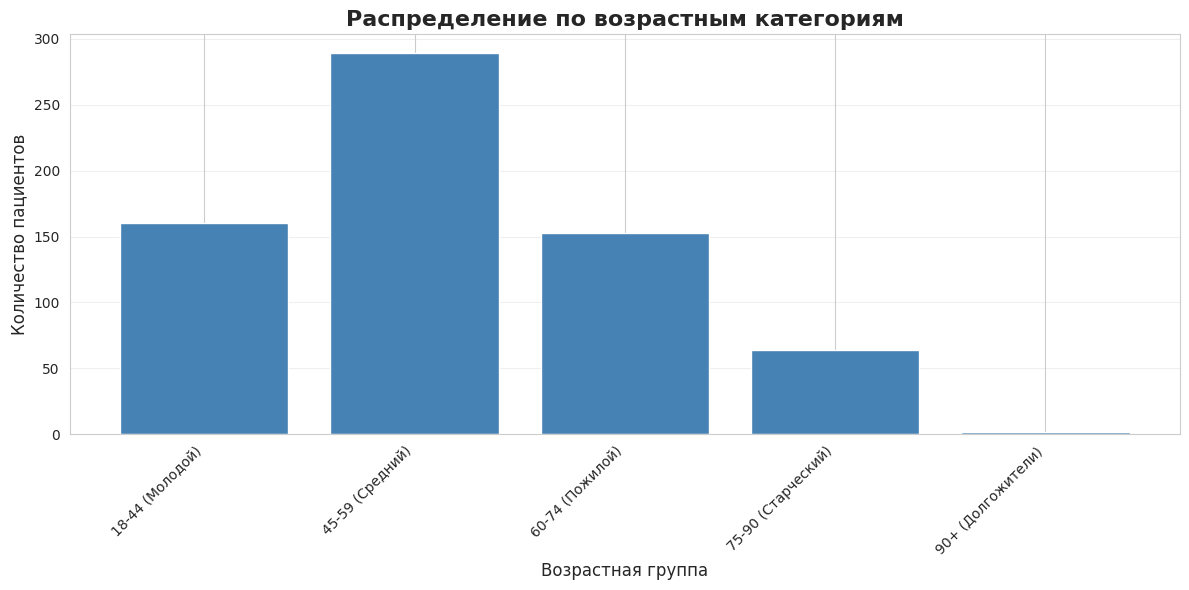

In [63]:
# Агрегация в Spark
age_counts = df.groupBy('age_category').count().orderBy('age_category')
df_pandas = age_counts.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(df_pandas['age_category'], df_pandas['count'], color='steelblue')
plt.xlabel('Возрастная группа', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.title('Распределение по возрастным категориям', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## График временных трендов


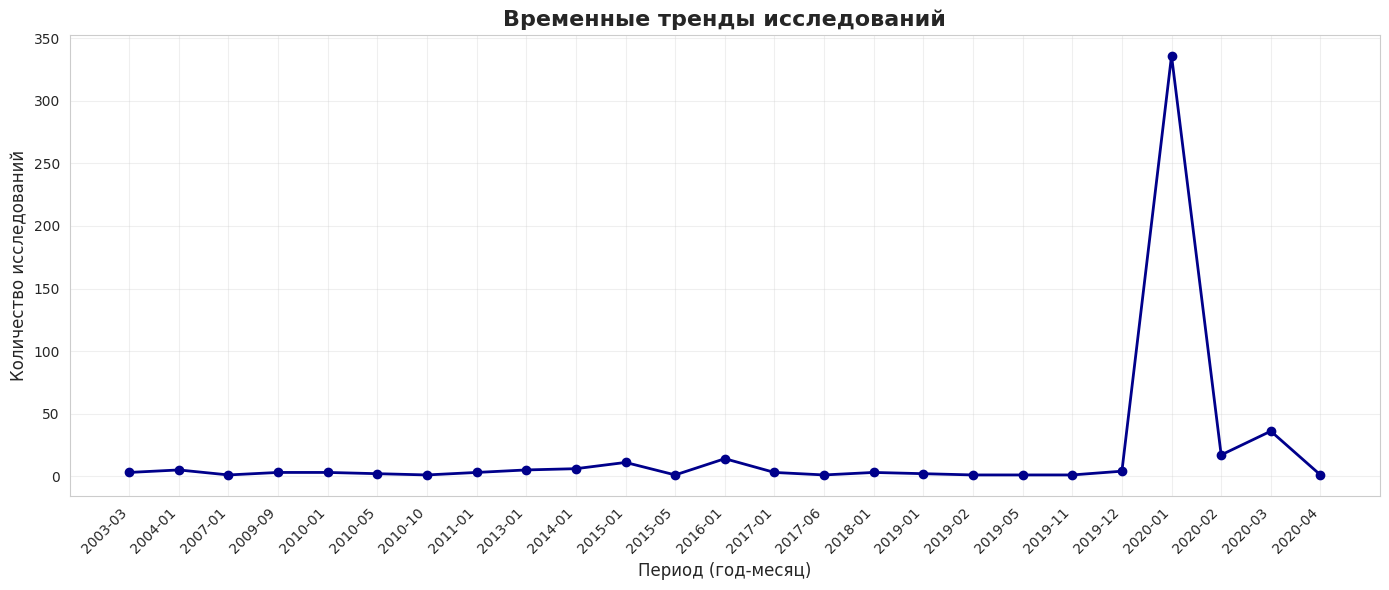


 Пиковый период: 2020-01 (336 исследований)


In [64]:
# Создаем year_month в Spark
temporal_data = df.filter(col('date').isNotNull()) \
    .withColumn('year', year(col('date'))) \
    .withColumn('month', month(col('date'))) \
    .withColumn('year_month', concat(
        col('year').cast('string'),
        lpad(col('month').cast('string'), 2, '0')
    ))

# Группируем в Spark
trend_spark = temporal_data.groupBy('year_month').count() \
    .orderBy('year_month')

# переводим в pandas
trend_data = trend_spark.toPandas()

# Форматируем для графика
trend_data['year_month_label'] = trend_data['year_month'].apply(
    lambda x: f"{x[:4]}-{x[4:]}"
)

plt.figure(figsize=(14, 6))
plt.plot(range(len(trend_data)), trend_data['count'],
         marker='o', linewidth=2, markersize=6, color='darkblue')

plt.xticks(range(len(trend_data)), trend_data['year_month_label'],
           rotation=45, ha='right')
plt.xlabel('Период (год-месяц)', fontsize=12)
plt.ylabel('Количество исследований', fontsize=12)
plt.title('Временные тренды исследований', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Статистика
peak_period = trend_data.loc[trend_data['count'].idxmax(), 'year_month_label']
peak_count = trend_data['count'].max()
print(f"\n Пиковый период: {peak_period} ({peak_count} исследований)")

## Heatmap распределения диагнозов по проекциям


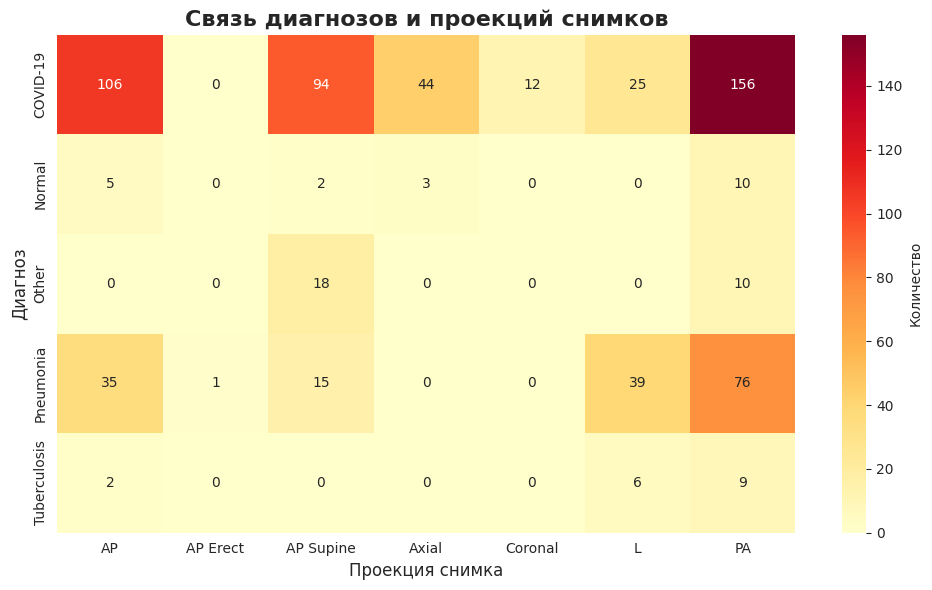

In [65]:
# Агрегация в Spark
heatmap_data = df.groupBy('finding_unified', 'view').count() \
    .orderBy('finding_unified', 'view')

df_pandas = heatmap_data.toPandas()

# Создаем pivot table
pivot_table = df_pandas.pivot(index='finding_unified', columns='view', values='count')
pivot_table = pivot_table.fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Количество'})
plt.title('Связь диагнозов и проекций снимков', fontsize=16, fontweight='bold')
plt.xlabel('Проекция снимка', fontsize=12)
plt.ylabel('Диагноз', fontsize=12)
plt.tight_layout()
plt.show()

In [66]:
df.unpersist()
spark.stop()